In [1]:
# Base imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import arviz as az

# Other imports
from numpy import pi as pi

# New plotting imports
import seaborn as sns

## Load the trace - GPGP Model

This run: gpgp-model with exponential kernels

In [2]:
trace = az.from_netcdf("posterior.nc")

## Basic results

<Axes: >

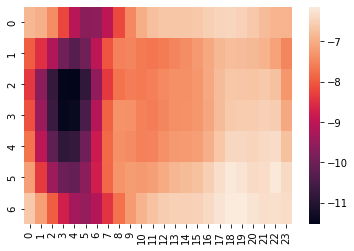

In [3]:
post_mean_mu = trace.posterior['mu'].mean(axis = (0,1)).to_numpy()
sns.heatmap(post_mean_mu.reshape(7,24))

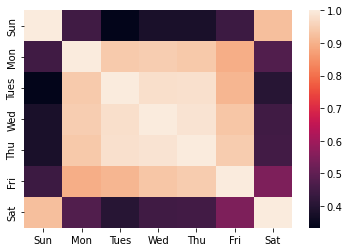

In [4]:
post_mean_daycorrs = trace.posterior['eta_omega_corr'].to_numpy().mean(axis = (0,1))
corr_plot = sns.heatmap(post_mean_daycorrs, xticklabels=['Sun','Mon','Tues',"Wed","Thu",'Fri','Sat'], yticklabels=['Sun','Mon','Tues',"Wed","Thu",'Fri','Sat'])
fig = corr_plot.get_figure()
fig.savefig("corrplot.pdf")

## Stacking the samples

This just simplifies subsequent code:

In [5]:
trace.stack(sample=["chain", "draw"], inplace = True)

## Posterior predictive

In [6]:
train = pd.read_csv("../../data/train.csv")
test = pd.read_csv("../../data/test.csv")

n_weeks_train = 38
n_people, n_weeks_total, n_samples = trace.posterior['alpha'].shape
n_dayhours = 168

# Training period data:
calls_by_week = train.groupby(['id','week'])['y'].sum()
id_week_idx = np.array(list(calls_by_week.index)) - 1
true_requests = np.zeros(shape = (n_people, n_weeks_train))
true_requests[id_week_idx[:,0], id_week_idx[:,1]] = train.groupby(["id", "week"])['y'].sum()

# Just test period data:
test_calls_by_week = test.groupby(['id','week'])['y'].sum()
id_week_idx = np.array(list(test_calls_by_week.index)) - 1
test_requests = np.zeros(shape = (n_people, n_weeks_total))
test_requests[id_week_idx[:,0], id_week_idx[:,1]] = test.groupby(["id", "week"])['y'].sum()
test_requests = test_requests[:,n_weeks_train:]

# Combined:
true_reqs_all = np.hstack((true_requests, test_requests))

Compute the decomposition:

In [7]:
# Routine part
decomp_routine = np.array([[np.median(np.exp(trace.posterior['eta'].values[i] + trace.posterior['gamma'].values[i,w]).sum(axis = 0)) for w in range(n_weeks_total)] for i in range(n_people)])

# "Random" part
decomp_random = np.array([[np.median(np.exp(trace.posterior['alpha'].values[i,w] + trace.posterior['mu'].values).sum(axis = 0)) for w in range(n_weeks_total)] for i in range(n_people)])

Quick comparison: expected vs. actual (NOT accounting for acquisition date)

Text(0.5, 0, 'Expected')

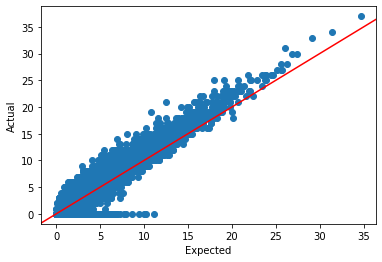

In [8]:
fig, ax = plt.subplots()
ax.scatter(decomp_routine[:,:n_weeks_train] + decomp_random[:,:n_weeks_train], true_requests)
ax.axline([1,1], slope=1, color="red")
ax.set_ylabel("Actual")
ax.set_xlabel("Expected")


Compute posterior predictive of number of future requests:

In [9]:
ppd_reqs = np.array([[(np.exp(trace.posterior['eta'].values[i] + trace.posterior['gamma'].values[i,w]) + \
    np.exp(trace.posterior['alpha'].values[i,w] + trace.posterior['mu'].values)).sum(axis=0) for w in range(n_weeks_total)] for i in range(n_people)])
expected_reqs = np.median(ppd_reqs, axis = 2)
E_train_reqs = expected_reqs[:,:38]
E_fore_reqs = expected_reqs[:,38:]

Plot true vs. expected, over all data:

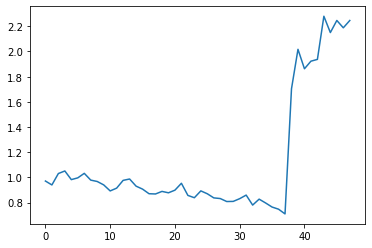

In [10]:
plt.plot(np.sqrt(np.mean((true_reqs_all - expected_reqs)**2, axis = 0)))

### Holdout error:

In [11]:
abs_err = np.abs(test_requests.sum(1) - E_fore_reqs.sum(1))
abs_err.mean()

7.727934564746465

In [12]:
print(f"95% ci: {abs_err.mean() - 2*abs_err.std()/np.sqrt(len(abs_err))}, {abs_err.mean() + 2*abs_err.std()/np.sqrt(len(abs_err))}")

95% ci: 7.171456478979582, 8.284412650513348
